<a href="https://colab.research.google.com/github/chandini2595/DeepLearning-Experiments/blob/main/Wildlife_Prediction_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb



In [ ]:
import wandb
wandb.init(project="wildfire-prediction")

In [ ]:
# Load an inbuilt dataset (Forest Fires dataset from OpenML)
dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv")

# Selecting relevant features and target
features = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
dataset['fire'] = (dataset['area'] > 0).astype(int)  # Convert area > 0 to wildfire occurrence

df = dataset[features + ['fire']]

In [ ]:
# Splitting dataset
X = df[features].values
y = df['fire'].values

# Standardizing input features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Splitting into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [ ]:
# Define the Deep Learning model
def create_wildfire_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Train the model
model = create_wildfire_model(len(features))
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=50, batch_size=16, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.4977 - loss: 0.9354 - val_accuracy: 0.5192 - val_loss: 0.6867
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5467 - loss: 0.7898 - val_accuracy: 0.5385 - val_loss: 0.6892
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5166 - loss: 0.8316 - val_accuracy: 0.5577 - val_loss: 0.6868
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5028 - loss: 0.8128 - val_accuracy: 0.5673 - val_loss: 0.6837
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5507 - loss: 0.7455 - val_accuracy: 0.5865 - val_loss: 0.6835
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5463 - loss: 0.7374 - val_accuracy: 0.5769 - val_loss: 0.6799
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5436 - loss: 0.7947 - val_accuracy: 0.5769 - val_loss: 0.6793
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5839 - loss: 0.7419 - val_accuracy: 0.5481 - v

In [ ]:
# Predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [ ]:

# Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
wab_report = classification_report(y_test, y_pred)
wandb.log({"classification_report": wab_report})
print(wab_report)

              precision    recall  f1-score   support

           0       0.69      0.40      0.51        50
           1       0.60      0.83      0.70        54

    accuracy                           0.62       104
   macro avg       0.64      0.62      0.60       104
weighted avg       0.64      0.62      0.61       104



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step 


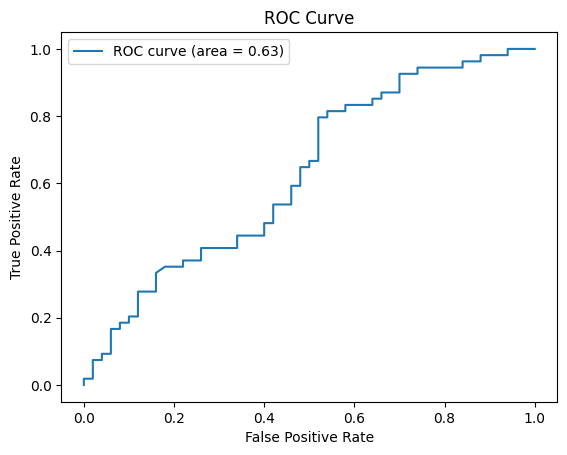

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


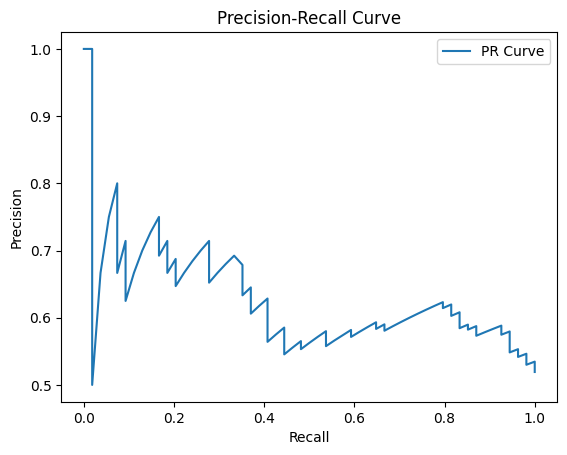

<Figure size 640x480 with 0 Axes>

In [ ]:
# ROC & PR Curve
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
wandb.log({"roc_auc": roc_auc})

precision, recall, _ = precision_recall_curve(y_test, model.predict(X_test))
plt.figure()
plt.plot(recall, precision, label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
wandb.log({"precision_recall_curve": wandb.Image(plt)})
